In [ ]:
# ============================================================
# SETUP
# ============================================================
!pip install -q scikit-learn seaborn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv("/content/all-data.csv", encoding="latin1")
df.columns = ["label", "text"]
df["text"] = df["text"].astype(str)

print("Shape:", df.shape)
df.head()

Shape: (4845, 2)


,label,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

df['text'] = df['text'].apply(clean_text)

print("Text column cleaned successfully. Displaying first 5 rows of cleaned data:")
display(df.head())

Text column cleaned successfully. Displaying first 5 rows of cleaned data:


,label,text
0,neutral,technopolis plans to develop in stages an area...
1,negative,the international electronic industry company ...
2,positive,with the new production plant the company woul...
3,positive,according to the company s updated strategy fo...
4,positive,financing of aspocomp s growth aspocomp is agg...


label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


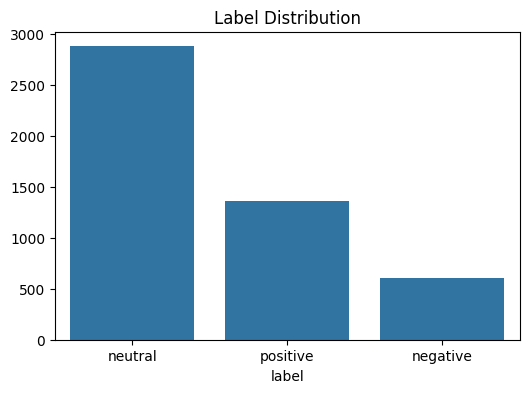

In [ ]:
label_counts = df["label"].value_counts()
print(label_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.show()

Mean length: 20.48937048503612
Median length: 19.0


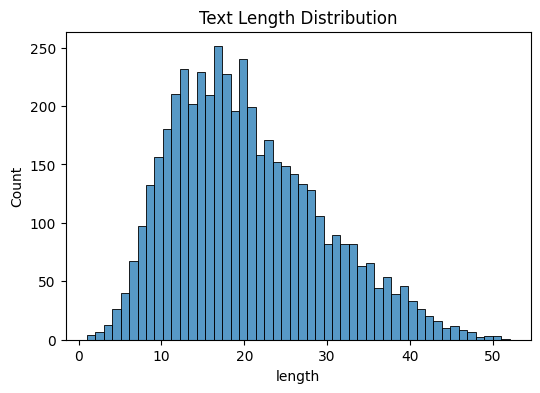

In [ ]:
df["length"] = df["text"].apply(lambda x: len(x.split()))

print("Mean length:", df["length"].mean())
print("Median length:", df["length"].median())

plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=50)
plt.title("Text Length Distribution")
plt.show()

In [ ]:
label2id = {label: i for i, label in enumerate(df["label"].unique())}
id2label = {v: k for k, v in label2id.items()}

df["label_id"] = df["label"].map(label2id)

print(label2id)

{'neutral': 0, 'negative': 1, 'positive': 2}


In [ ]:
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label_id"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.6667, stratify=temp_df["label_id"], random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (3391, 4)
Val: (484, 4)
Test: (970, 4)


In [ ]:
def build_vocab(texts, max_vocab=20000):
    counter = Counter()
    for text in texts:
        counter.update(text.lower().split())
    vocab = counter.most_common(max_vocab-2)
    word2idx = {"<PAD>":0, "<UNK>":1}
    for i,(word,_) in enumerate(vocab):
        word2idx[word] = i+2
    return word2idx

word2idx = build_vocab(train_df["text"])
vocab_size = len(word2idx)

print("Vocabulary size:", vocab_size)

Vocabulary size: 9169


In [ ]:
MAX_LEN = 100

def encode(text):
    tokens = text.lower().split()
    ids = [word2idx.get(t,1) for t in tokens]
    ids = ids[:MAX_LEN]
    ids += [0]*(MAX_LEN-len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.texts[idx]))
        y = torch.tensor(self.labels[idx])
        return x, y

In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(TextDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TextDataset(val_df), batch_size=BATCH_SIZE)
test_loader = DataLoader(TextDataset(test_df), batch_size=BATCH_SIZE)

In [ ]:
class RCNN(nn.Module):
    def __init__(self, vocab_size, num_classes,
                 embed_dim=128, hidden_dim=128):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.bilstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.W = nn.Linear(
            embed_dim + 2*hidden_dim,
            hidden_dim
        )

        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):

        embed = self.embedding(x)             # (B,T,E)

        context, _ = self.bilstm(embed)       # (B,T,2H)

        concat = torch.cat([context, embed], dim=2)

        y = self.tanh(self.W(concat))         # (B,T,H)

        y = torch.max(y, dim=1)[0]            # Global max pooling

        out = self.classifier(y)

        return out

In [ ]:
model = RCNN(
    vocab_size=vocab_size,
    num_classes=len(label2id)
).to(device)

print("Total parameters:",
      sum(p.numel() for p in model.parameters()))

Total parameters: 1487491


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
EPOCHS = 15

In [ ]:
start_time = time.time()

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for x,y in train_loader:

        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits,y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss {total_loss/len(train_loader):.4f}")

train_time = time.time() - start_time
print("Training time (seconds):", train_time)

Epoch 1 | Loss 0.9441
Epoch 2 | Loss 0.8603
Epoch 3 | Loss 0.8162
Epoch 4 | Loss 0.7686
Epoch 5 | Loss 0.7156
Epoch 6 | Loss 0.6658
Epoch 7 | Loss 0.6153
Epoch 8 | Loss 0.5657
Epoch 9 | Loss 0.4980
Epoch 10 | Loss 0.4371
Epoch 11 | Loss 0.3746
Epoch 12 | Loss 0.3148
Epoch 13 | Loss 0.2563
Epoch 14 | Loss 0.2171
Epoch 15 | Loss 0.1710
Training time (seconds): 361.03389620780945


In [ ]:
def evaluate(loader):

    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)

            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(labels), np.array(preds)

In [ ]:
y_true, y_pred = evaluate(test_loader)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))

Accuracy: 0.6845360824742268
Macro F1: 0.613532857978433
Weighted F1: 0.6826419085376118


In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(id2label))]
))

              precision    recall  f1-score   support

     neutral       0.77      0.79      0.78       576
    negative       0.50      0.52      0.51       121
    positive       0.58      0.53      0.55       273

    accuracy                           0.68       970
   macro avg       0.61      0.61      0.61       970
weighted avg       0.68      0.68      0.68       970



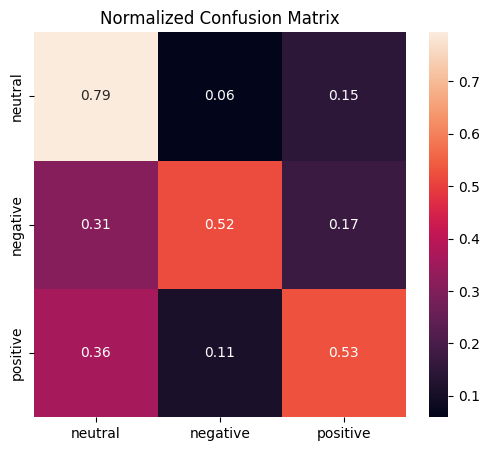

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt=".2f",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024**2
print("Model size (MB):", model_size)

Model size (MB): 5.674327850341797
